In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ykucheri_0000158090
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [4]:
slice_name="Rtt-analysis" + fablib.get_bastion_username()

node_conf = [
 {'name': "nodea",   'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "nodeb",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "router",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]
net_conf = [
 {"name": "net_a", "subnet": "10.10.1.0/24", "nodes": [{"name": "nodea",  "addr": "10.10.1.100"}, {"name": "router", "addr": "10.10.1.10"}]},
 {"name": "net_b", "subnet": "10.10.2.0/24", "nodes": [{"name": "nodeb", "addr": "10.10.2.100"}, {"name": "router", "addr": "10.10.2.10"}]},
]
route_conf = [
 {"addr": "10.10.1.0/24", "gw": "10.10.2.10", "nodes": ["nodeb"]}, 
 {"addr": "10.10.2.0/24", "gw": "10.10.1.10", "nodes": ["nodea"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

In [5]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [9]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,LOSA
State,Active
Address,"818 West 7th Street,Los Angeles, CA 90017"
Location,"(34.04908028571428, -118.25953404081633)"
PTP Capable,False
Hosts,3
CPUs,6
Cores Available,68
Cores Capacity,384
Cores Allocated,316
RAM Available,882


'<pandas.io.formats.style.Styler object at 0x7f2fd676af80>'

In [10]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [11]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

In [12]:
slice.submit()


Retry: 11, Time: 344 sec


ID,069ead64-181b-4514-9ec0-5263cbd1f85b
Name,Rtt-analysisykucheri_0000158090
Lease Expiration (UTC),2024-05-01 03:54:08 +0000
Lease Start (UTC),2024-04-30 03:54:09 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
a5ec9125-938a-46a8-9087-123f176220da,nodea,2,4,10,default_ubuntu_20,qcow2,losa-w2.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fec5:e6c3,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fec5:e6c3,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
3cfa25e3-9cc4-4a09-ac14-cf4c22f27756,nodeb,2,4,10,default_ubuntu_20,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fe83:eaee,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe83:eaee,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
9ed64df9-86ba-458d-bc77-aa0f9d6d42bb,router,2,4,10,default_ubuntu_20,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fe3e:dc20,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe3e:dc20,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
9abc10ff-56ff-4791-acaa-a87238dd51e4,net_a,L2,L2Bridge,LOSA,None,None,Active,
7c8c83f2-24ed-4304-8853-34e1c9b8f3ea,net_b,L2,L2Bridge,LOSA,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
nodea-net_a-p1,p1,nodea,net_a,100,config,,46:F2:9C:CE:09:57,enp6s0,enp6s0,None,4
nodeb-net_b-p1,p1,nodeb,net_b,100,config,,06:08:75:E3:98:05,enp6s0,enp6s0,None,4
router-net_b-p1,p1,router,net_b,100,config,,1A:02:51:44:43:0F,enp7s0,enp7s0,None,4
router-net_a-p1,p1,router,net_a,100,config,,06:8C:9E:8B:C0:2F,enp6s0,enp6s0,None,4



Time to print interfaces 350 seconds


'069ead64-181b-4514-9ec0-5263cbd1f85b'

In [13]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

In [6]:
slice = fablib.get_slice(name=slice_name)

In [7]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [8]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [9]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.1.100 nodea
10.10.1.10 router
10.10.2.100 nodeb
10.10.2.10 router
10.10.1.100 nodea
10.10.1.10 router
10.10.2.100 nodeb
10.10.2.10 router
10.10.1.100 nodea
10.10.1.10 router
10.10.2.100 nodeb
10.10.2.10 router


In [10]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [11]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [12]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

In [13]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

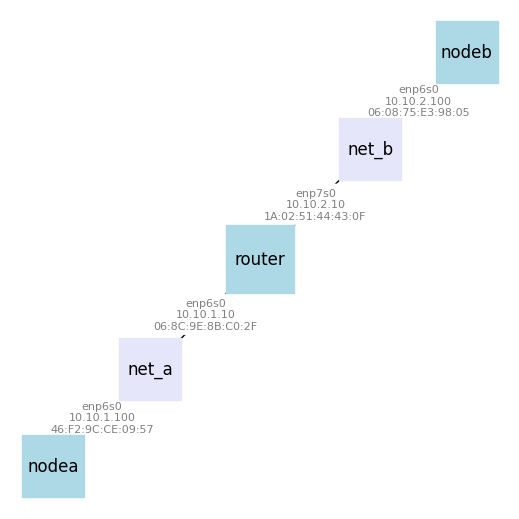

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [15]:
#log into resources
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
nodea,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fec5:e6c3
nodeb,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe83:eaee
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe3e:dc20


In [18]:
!pip install scapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444326 sha256=f5e7a3ade4881ff0ccdcd11a8333feedb23785de6d955c574a0f606c916e4b21
  Stored in directory: /home/fabric/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


In [ ]:
#Scapy to calculateRTT
#did not execute this yet
import time
from scapy.all import IP, ICMP, sr1
import statistics

def calculate_rtt(ip_address, count=4):
    rtt_list = []

    for _ in range(count):
        start_time = time.time()
        packet = IP(dst=ip_address) / ICMP()
        
        # Send the packet and receive a response
        reply = sr1(packet, timeout=1, verbose=False)

        if reply:
            # Calculate round trip time in milliseconds
            rtt = (time.time() - start_time) * 1000
            rtt_list.append(rtt)
        else:
            # Set a large value for timeout or packet loss
            rtt_list.append(float('inf'))

    return rtt_list

def main():
    # Put IPs of Nodes in different sites you want to test
    ip1 = '10.10.1.100'
    ip2 = '8.8.8.8'
    num_readings = 1000

    all_rtt1 = []
    all_rtt2 = []

    for _ in range(num_readings):
        rtt1 = calculate_rtt(ip1)
        rtt2 = calculate_rtt(ip2)

        all_rtt1.extend(rtt1)
        all_rtt2.extend(rtt2)

    median_rtt1 = statistics.median(all_rtt1)
    median_rtt2 = statistics.median(all_rtt2)

    print(f"Median RTT from {ip1}: {median_rtt1} ms")
    print(f"Median RTT from {ip2}: {median_rtt2} ms")

if __name__ == "__main__":
    main()